In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bigfile import BigFile
import glob,os,struct
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology
import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc


In [2]:
merger_root = "/hildafs/datasets/Asterix/BH-mergers"
merger_files = glob.glob(merger_root + "/bh-merger-extended*.npy")
merger_files.sort()

mergers = []
for file in merger_files:
    mergers.append(np.load(file))
mergers = np.concatenate(mergers)

print("merger data fields:", mergers.dtype.names)
print("merger shape:", mergers.shape)


merger data fields: ('z', 'ID1', 'ID2', 'm1', 'm2', 'mdot1', 'mdot2', 'pos1', 'pos2', 'v1', 'v2')
merger shape: (688213,)


In [3]:
def load_astrid_cosmo():
    pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_214')
    battr = pig["Header"].attrs
    Lbox = battr['BoxSize']
    hh = battr['HubbleParam']
    om0 = battr['Omega0']
    omb = battr['OmegaBaryon']
    oml = battr['OmegaLambda']
    Nfof = battr['NumFOFGroupsTotal']
    sigma8 = 0.82

    # set-up cosmology
    params = {'flat': True, 'H0': 100*hh, 'Om0': om0, 'Ob0': omb, 'sigma8': sigma8, 'ns': 0.96}
    cosmo = cosmology.setCosmology('myCosmo', params)
    MassTable = battr["MassTable"]
    
    return Lbox, MassTable, cosmo

snaps = np.loadtxt('/hildafs/datasets/Asterix/PIG2/Snapshots.txt')
snap2z = {s[0]:1./s[1]-1 for s in snaps}
snap2z[147]

# some constants and unit conversions
msun_mks = 1.989e30
pc_mks = 3.086e16
grav_mks = 6.67e-11
km_mks = 1e3
yr_mks = 3.154e+7
c_mks = 3e8

Mpc_to_m = 3.086e+22
m_to_Mpc = 1./Mpc_to_m
s_to_year = 3.17098e-8
c_Mpc_yr = c_mks*m_to_Mpc/s_to_year
fac = 121.14740013761634  # GADGET unit Protonmass / Bolztman const
GAMMA = 5 / 3.
Xh=0.76
hh = h = 0.6774

Lbox, MassTable, cosmo = load_astrid_cosmo()
# conversion between time and redshift
z_arr = np.linspace(0,20,1000)
time = cosmo.age(z_arr) # Gyr
def z_to_t(x):
    return interp1d(z_arr, time,fill_value='extrapolate')(x)
def t_to_z(x):
    return interp1d(time, z_arr,fill_value='extrapolate')(x) 

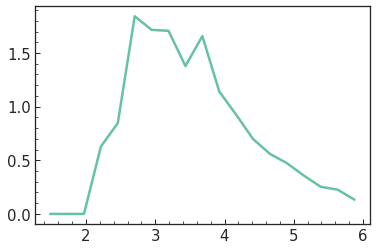

In [4]:
vsim = 250**3
zbin = np.linspace(1.36,6,20)
dz = zbin[1:] - zbin[:-1]
zc = 0.5*(zbin[1:]+zbin[:-1])
rc = np.array([cosmo.comovingDistance(0.,zz) for zz in zc])

n0,e0 = np.histogram(np.concatenate([mergers['z']]),bins=zbin)

rate0 = n0/dz/vsim*4*np.pi*rc**2*c_Mpc_yr

plt.plot(zc, rate0)
# plt.yscale('log')


In [2]:
import matplotlib
matplotlib.matplotlib_fname()

'/hildafs/projects/phy200018p/nianyic/conda/default/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'

In [10]:
root = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat"
file1 = root + "/Astrid_z3_binary_recoil_cat.npy"
file2 = root + "/post_merger_below3.npy"

In [11]:
data1 = np.load(file1)
data2 = np.load(file2)

print(data1.dtype)
print(data2.dtype)
print(len(data1))
print(len(data2))

[('id1', '<i8'), ('id2', '<i8'), ('id3', '<i8'), ('zmerge', '<f8'), ('mass1', '<f8'), ('mass2', '<f8'), ('sigma1', '<f8'), ('sigma2', '<f8'), ('sigma_rem', '<f8'), ('rho_1kpc', '<f8'), ('gamma', '<f8'), ('mstot', '<f8'), ('rhalf', '<f8'), ('mass3', '<f8'), ('znext', '<f8')]
[('zmerge', '<f8'), ('id1', '<i8'), ('id2', '<i8'), ('m1', '<f8'), ('m2', '<f8'), ('m4tot', '<f8'), ('mhtot', '<f8'), ('sigma', '<f8'), ('rho', '<f8'), ('gamma', '<f8'), ('zsnap', '<f8'), ('snap_num', '<i4')]
441077
1775786


### append zsnap for z>3 catalog

In [46]:
snap_root = "/hildafs/datasets/Asterix/BH_details/postprocess/binary_galaxy/z4"
fflist = sorted(glob.glob(snap_root + "/binary_merged*.pkl"))
snaplist = [int(ff.split("/")[-1].split("_")[2]) for ff in fflist]
snaplist = np.unique(snaplist)
print(snaplist)


[ 17  18  20  21  22  23  25  27  29  31  33  35  36  39  41  43  47  49
  51  55  58  62  66  73  84 107 113 118 122 125 126 128 130 131 133 134
 136 137 139 142 144 147 149 151 153 155 158 161 163 166 170 174 177 181
 184 187 190 194 198 202 207 214]


In [47]:
# from snapshot number to redshift
snaps = np.loadtxt('/hildafs/datasets/Asterix/PIG2/Snapshots.txt')
snap2z = {s[0]:1./s[1]-1 for s in snaps}

zlist = [snap2z[s] for s in snaplist]
print(zlist)

[9.99999890000011, 9.519373003291513, 9.0, 8.740038375751201, 8.301287298162066, 8.000009000009, 7.852142661131127, 7.579493295125991, 7.223887102477857, 7.0, 6.827298486200472, 6.73413149570369, 6.639652854174305, 6.500018750046875, 6.373924328788537, 6.250001812500453, 6.000007000007, 5.889519662689118, 5.8039245036537075, 5.686637423772334, 5.600442229629385, 5.500006500006499, 5.4070528838145036, 5.2889126470033325, 5.195902030397095, 4.999988000024, 4.906953665855445, 4.801036065041216, 4.70226208737006, 4.608021714260078, 4.56049822064057, 4.5000055000055, 4.452235689244375, 4.412749189440809, 4.330746144537851, 4.28518878694347, 4.25000525000525, 4.218090074670869, 4.162675918181912, 4.105635600575916, 4.056608734785929, 4.0, 3.952137590190806, 3.9000872215525435, 3.8439520836259895, 3.8078078799971147, 3.750007125010688, 3.699999060000188, 3.657878801993572, 3.5966233205087548, 3.5407074422194977, 3.5000045000044997, 3.456010266647654, 3.395237320839139, 3.3532392453224444, 3.2

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

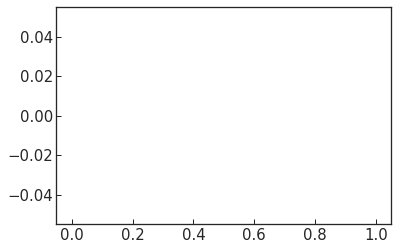

In [59]:

mask = zsnap == 0
dd = data1[mask]
plt.hist(dd["zmerge"])

In [61]:
min(zsnap)

3.0

In [58]:
zsnap = np.zeros(len(data1))
for i,zz in enumerate(zlist):
    mask  = data1["zmerge"] >= zz
    if i != 0:
        mask &= data1["zmerge"] < zlist[i-1]
    zsnap[mask] = zz
    print(len(data1[mask]))

0
4
23
18
74
96
90
212
474
466
506
357
398
718
805
1040
2634
1425
1297
2060
1752
2292
2451
3666
3365
8731
4861
6652
6767
7058
4051
5261
4290
3909
8523
4837
4332
3362
7427
7789
6950
9557
8228
9662
11469
7143
11792
11063
14484
19252
14811
11243
12271
18389
13157
18681
17012
18203
31135
19837
21514
21151


In [62]:
data1["znext"] = zsnap

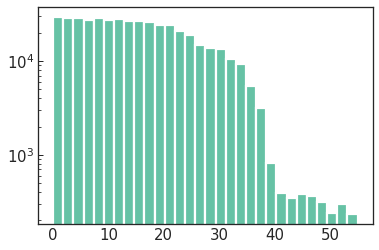

In [71]:
plt.hist((z_to_t(data1["znext"]) - z_to_t(data1["zmerge"]))*1e3, bins=30)
plt.yscale("log")

### concatenate data and remove duplicates

In [72]:
data1_short = [(d["id1"], d["id2"], d["zmerge"], d["mass1"], d["mass2"], d["mstot"], d["znext"]) for d in data1]
data2_short = [(d["id1"], d["id2"], d["zmerge"], d["m1"], d["m2"], d["m4tot"], d["zsnap"]) for d in data2]



names = ["id1", "id2", "zmerge", "m1", "m2", "mstot", "zsnap"]
types = ["q", "q", "d", "d", "d", "d", "d"]
dtype = np.dtype(list(zip(names, types)))

data1_short = np.array(data1_short, dtype = dtype)
data2_short = np.array(data2_short, dtype = dtype)

data_short = np.concatenate([data1_short, data2_short])
print(len(data_short))
print(data_short.dtype)


2216863
[('id1', '<i8'), ('id2', '<i8'), ('zmerge', '<f8'), ('m1', '<f8'), ('m2', '<f8'), ('mstot', '<f8'), ('zsnap', '<f8')]


In [73]:
swbh = np.minimum(data_short["id1"], data_short["id2"])

uid, uidx = np.unique(swbh, return_index=True)
data_unique = data_short[uidx]

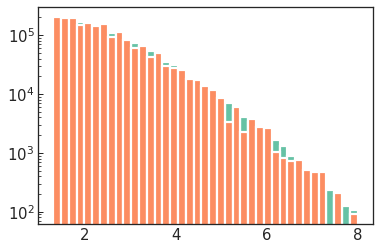

In [74]:
bins = np.linspace(1.3,8,40)

plt.hist(data_unique["zmerge"], bins = bins)
plt.hist(data_unique["zsnap"], bins=bins)
plt.yscale('log')
plt.show()

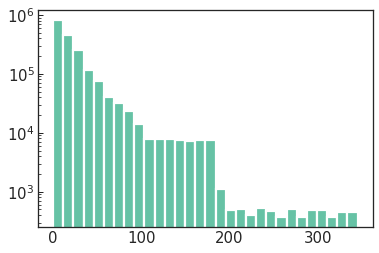

In [76]:
plt.hist((z_to_t(data_unique["zsnap"]) - z_to_t(data_unique["zmerge"]))*1e3, bins=30)
plt.yscale("log")

(array([38180., 14694.,     0.,     0.,   678.,  2031.,  1988.,  1767.,
         1743.,  1595.]),
 array([2.80738399, 2.87664604, 2.94590809, 3.01517014, 3.0844322 ,
        3.15369425, 3.2229563 , 3.29221835, 3.3614804 , 3.43074245,
        3.5000045 ]),
 <BarContainer object of 10 artists>)

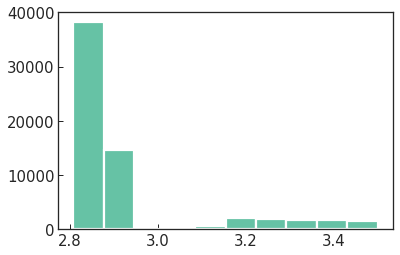

In [79]:
mask = (z_to_t(data_unique["zsnap"]) - z_to_t(data_unique["zmerge"]))*1e3 > 100
plt.hist(data_unique["zmerge"][mask])

In [81]:
# root = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat"
# np.save(root + "/lisa_mcat_v1.0_z1.3.npy", data_unique)

### sanity checks

In [82]:
root = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat"

data_unique = np.load(root + "/lisa_mcat_v1.0_z1.3.npy")

In [83]:
def load_astrid_cosmo():
    pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_214')
    battr = pig["Header"].attrs
    Lbox = battr['BoxSize']
    hh = battr['HubbleParam']
    om0 = battr['Omega0']
    omb = battr['OmegaBaryon']
    oml = battr['OmegaLambda']
    Nfof = battr['NumFOFGroupsTotal']
    sigma8 = 0.82

    # set-up cosmology
    params = {'flat': True, 'H0': 100*hh, 'Om0': om0, 'Ob0': omb, 'sigma8': sigma8, 'ns': 0.96}
    cosmo = cosmology.setCosmology('myCosmo', params)
    MassTable = battr["MassTable"]
    
    return Lbox, MassTable, cosmo

snaps = np.loadtxt('/hildafs/datasets/Asterix/PIG2/Snapshots.txt')
snap2z = {s[0]:1./s[1]-1 for s in snaps}
snap2z[147]

# some constants and unit conversions
msun_mks = 1.989e30
pc_mks = 3.086e16
grav_mks = 6.67e-11
km_mks = 1e3
yr_mks = 3.154e+7
c_mks = 3e8

Mpc_to_m = 3.086e+22
m_to_Mpc = 1./Mpc_to_m
s_to_year = 3.17098e-8
c_Mpc_yr = c_mks*m_to_Mpc/s_to_year
fac = 121.14740013761634  # GADGET unit Protonmass / Bolztman const
GAMMA = 5 / 3.
Xh=0.76
hh = h = 0.6774

Lbox, MassTable, cosmo = load_astrid_cosmo()
# conversion between time and redshift
z_arr = np.linspace(0,20,1000)
time = cosmo.age(z_arr) # Gyr
def z_to_t(x):
    return interp1d(z_arr, time,fill_value='extrapolate')(x)
def t_to_z(x):
    return interp1d(time, z_arr,fill_value='extrapolate')(x) 

In [85]:
min(data_unique["zmerge"])

1.3161556147823728

total mergers: 1880977


dtype([('z', '<f8'), ('ID1', '<i8'), ('ID2', '<i8'), ('m1', '<f8'), ('m2', '<f8')])

In [88]:
vsim = 250**3
zbin = np.linspace(1.316,6,40)
dz = zbin[1:] - zbin[:-1]
zc = 0.5*(zbin[1:]+zbin[:-1])
rc = np.array([cosmo.comovingDistance(0.,zz) for zz in zc])

n0,e0 = np.histogram(data_unique["zmerge"],bins=zbin)
rate0 = n0/dz/vsim*4*np.pi*rc**2*c_Mpc_yr

Text(0.5, 1.0, 'Merger Rate')

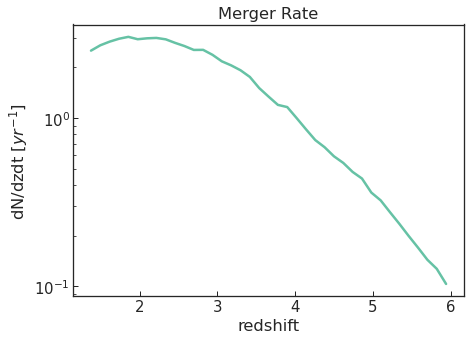

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(zc, rate0)
ax.set(xlabel="redshift", ylabel=r"dN/dzdt [$yr^{-1}$]", yscale="log")
# plt.yscale('log')
ax.set_title("Merger Rate")


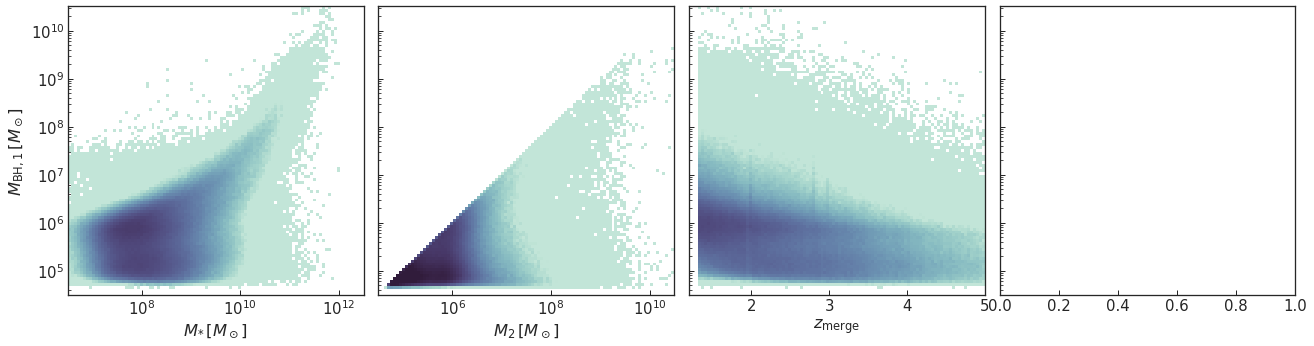

In [37]:
import matplotlib as mpl
cc3 = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)



fig, ax = plt.subplots(1,4,figsize=(22,5.3), sharey=True)
plt.subplots_adjust(wspace=0.05)
ax = ax.flatten()


ymin, ymax = 4.5, 10.5
xmin, xmax = 6.5, 12.5


xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)
ax[0].hist2d(data_unique['mstot'], data_unique['m1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[0].set(xscale='log', yscale='log', xlabel=r'$M_{*}\,[M_\odot]$', ylabel=r'$M_{\rm BH, 1}\,[M_\odot]$')


ymin, ymax = 4.5, 10.5
xmin, xmax = 4.5, 10.5

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

ax[1].hist2d(data_unique['m1'], data_unique['m2'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[1].set(xscale='log', yscale='log', xlabel=r'$M_{\rm 2}\,[M_\odot]$')


ymin, ymax = 4.5, 10.5
xmin, xmax = 1.2, 5

xbins = np.linspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

ax[2].hist2d(data_unique['zmerge'], data_unique['m1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[2].set(yscale='log', xlabel=r'$z_{\rm merge}$')





# ymin, ymax = 4.5, 10.5
# xmin, xmax = 1.3, 10

# xbins = np.linspace(xmin,xmax, 100)
# ybins = np.logspace(ymin,ymax, 100)

# ax[3].hist2d(mergers['zseed1'], mergers['m1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
# ax[3].set(xscale='log', yscale='log', xlabel=r'$M_{\rm seed, 1}\,[M_\odot]$')



plt.show()

In [ ]:
mergers1 = np.load('/hildafs/datasets/Asterix/BH_details_bigfile/ASTRID-merger-catalog-z2.npy')
mergers2 = np.load('/hildafs/datasets/Asterix/BH_details_bigfile2/mergers_below2/merger_cat_below2.npy')
mergers = np.concatenate([mergers1, mergers2])
print('total mergers:', len(mergers), flush=True)
mergers.dtype

In [ ]:
vsim = 250**3
zbin = np.linspace(1.7,6,20)
dz = zbin[1:] - zbin[:-1]
zc = 0.5*(zbin[1:]+zbin[:-1])
rc = np.array([cosmo.comovingDistance(0.,zz) for zz in zc])

n0,e0 = np.histogram(np.concatenate([data2["zmerge"], data1["zmerge"]]),bins=zbin)

rate0 = n0/dz/vsim*4*np.pi*rc**2*c_Mpc_yr



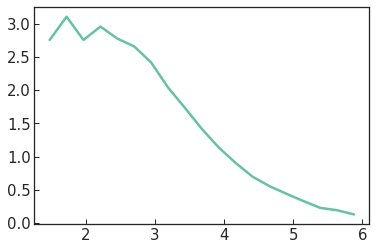

In [64]:
vsim = 250**3
zbin = np.linspace(1.36,6,20)
dz = zbin[1:] - zbin[:-1]
zc = 0.5*(zbin[1:]+zbin[:-1])
rc = np.array([cosmo.comovingDistance(0.,zz) for zz in zc])

n0,e0 = np.histogram(np.concatenate([mergers['z']]),bins=zbin)

rate0 = n0/dz/vsim*4*np.pi*rc**2*c_Mpc_yr

plt.plot(zc, rate0)
# plt.yscale('log')
